# Calculate and index rates and queue depths

this code will be run on a daily basis and does the following:
   * scans all the transfers that had submitted_at earlier than the end of the period and transferred_at later than the start of the period
   * calculates ingress and egress rates for all the links
   * calculates ingress and egress rates for all the sources and destinations
   * calculates queue depths for all the activities at all the sources (or should it be destinations)?
   * store all these data in a new ES index

#### to do:
   * check transfers where src==dest

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 12})

import requests
import pickle
import re
import datetime,time
from elasticsearch import Elasticsearch, helpers, exceptions as es_exceptions
from elasticsearch.helpers import scan
import datetime as dt

import numpy as np
import pandas as pd

es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

days_around=5

#cdt = datetime.datetime.utcnow()
cdt = datetime.datetime(2017,6,1,12,0,0) # noon of the given date

usefull functions

In [2]:
def store(docs_to_store):
    try:
       res = helpers.bulk(es, docs_to_store, raise_on_exception=True,request_timeout=60)
       #print("inserted:",res[0], '\tErrors:',res[1])
    except es_exceptions.ConnectionError as e:
       print('ConnectionError ', e)
    except es_exceptions.TransportError as e:
       print('TransportError ', e)
    except helpers.BulkIndexError as e:
       print(e[0])
       for i in e[1]:
          print(i)
    except Exception as e:
       print('Something seriously wrong happened.',e)

#### Get AGIS endpoints (RSEs) and site names

In [3]:
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']
print("total RSEs:", len(rse2site), "on",len(set(rse2site.values())),"sites.")


total RSEs: 931 on 145 sites.


#### Find indices to scan. We should scan at least 10 days before and 10 days after the day we are recalculating, so we cover all the very slow transfers.

In [4]:
indices = es.cat.indices(index="fts_*", h="index", request_timeout=600).split('\n')
indices = [x for x in indices if x != '']
indices = [x.strip() for x in indices]
#print(indices)

indices_to_scan=['fts_' + str(cdt.year) + '-' + str(cdt.month).zfill(2) + '-' + str(cdt.day).zfill(2)]

for d in range(1,days_around):
    bef = cdt - dt.timedelta(days=d)
    aft = cdt + dt.timedelta(days=d)
    ind_bef = 'fts_' + str(bef.year) + '-' + str(bef.month).zfill(2) + '-' + str(bef.day).zfill(2)
    ind_aft = 'fts_' + str(aft.year) + '-' + str(aft.month).zfill(2) + '-' + str(aft.day).zfill(2)
    if ind_bef in indices: indices_to_scan.append(ind_bef)
    if ind_aft in indices: indices_to_scan.append(ind_aft)
        
print(indices_to_scan)

['fts_2017-06-01', 'fts_2017-05-31', 'fts_2017-06-02', 'fts_2017-05-30', 'fts_2017-06-03', 'fts_2017-05-29', 'fts_2017-06-04', 'fts_2017-05-28', 'fts_2017-06-05']


#### Create structures to hold the data. Time bins are 1 minute.

In [ ]:
period_start = cdt.replace(hour=0).replace(minute=0).replace(second=0)
period_end   = cdt.replace(hour=23).replace(minute=59).replace(second=59)

bot = dt.datetime(1970,1,1)
index_name='fts-aggregates_' + str(period_start.year) + '-' + str(period_start.month)# + '-' + str(period_start.day)

ps = int((period_start - bot).total_seconds())
pe = int((period_end - bot).total_seconds())
print(period_start, period_end)

#caching periods
psb=int(ps/60)
pse=int(pe/60)
bins=[]
for t in range(psb,pse):
    bins.append(t*60)

endpoint_features = [ 'EndpointEgress', 'EndpointIgress', 'OutcomingTransfers', 'IncomingTransfers']
activities = [
    'Data_Consolidation', 'Production_Input', 'Data_Rebalancing', 'Production_Output', 'User_Subscriptions',
    'Data_Brokering', 'Express' 
    ]

class link:
    def __init__(self, src, dest):
        self.src=src
        self.dest=dest
        self.df=pd.DataFrame(0, index = bins, columns = [ 'rate' ]  + activities )
        self.df['rate']=self.df['rate'].astype('float64')
    def add_transfer(self, start_time, end_time, rate):
        st=int(start_time/60)
        et=int(end_time/60)
        area_covered = (et - st + 1) * 60 # area that will be covered in seconds
        actual_seconds = end_time - start_time
        scaled_rate = rate * actual_seconds / area_covered
        for ts in range(st,et+1):
            if ts>=psb and ts<pse: 
                timestamp = ts * 60
                val = self.df.get_value(timestamp, 'rate') + scaled_rate
                self.df.set_value(timestamp, 'rate', val)
    def add_queue(self, start_time, end_time, activity):
        if activity not in activities: return
        st=int(start_time/60)
        et=int(end_time/60)
        for ts in range(st,et+1):
            if ts>=psb and ts<pse: 
                timestamp = ts * 60
                val = self.df.get_value(timestamp, activity) + 1
                self.df.set_value(timestamp, activity, val)
    def stats(self):
        print(self.df.describe())
    def plot(self):
        to_plot = self.df.copy()
        to_plot = to_plot.loc[:,['rate']]
        to_plot.index = pd.to_datetime(to_plot.index, unit='s')
        to_plot.plot(style='-')
        plt.title(self.src + ' => '+self.dest)
        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        plt.show()
        plt.savefig(self.src+"_to_"+self.dest+'_rate.png')
    def plot_queues_depths(self):
        to_plot=self.df.copy()
        to_plot.index = pd.to_datetime(to_plot.index, unit='s')
        del to_plot['rate']
        to_plot.plot(style='-')
        plt.title(self.src+'=>'+self.dest)
        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        plt.show()
        plt.savefig(self.src+"_to_"+self.dest+'_queues.png')
    def get_json_docs(self):
        docs=[]
        for index, row in self.df.iterrows():
            doc = {
                '_index':index_name,
                '_type' : 'link',
                'timestamp' : int(index*1000),
                'src' : self.src,
                'dest' : self.dest,
                'rate' : int(row['rate'])
            }
            for activity in activities:
                if int(row[activity])>0: doc[activity]=int(row[activity])
            docs.append(doc)
        return docs
    
class endpoint:
    def __init__(self, name):
        self.name=name
        self.df=pd.DataFrame(0, index = bins, columns = endpoint_features)
        self.df['EndpointIgress'] = self.df['EndpointIgress'].astype('float64')
        self.df['EndpointEgress'] = self.df['EndpointEgress'].astype('float64')
    def add_transfer(self, start_time, end_time, rate, direction):
        st=int(start_time/60)
        et=int(end_time/60)
        area_covered = (et-st+1)*60 # area that will be covered in seconds
        actual_seconds = end_time - start_time
        scaled_rate = rate * actual_seconds / area_covered
        if direction: 
            drct='EndpointIgress'
            drct1='IncomingTransfers'
        else:
            drct='EndpointEgress'
            drct1='OutcomingTransfers'
        for ts in range(st,et+1):
            if ts>=psb and ts<pse: 
                timestamp = ts * 60
                val = self.df.get_value(timestamp, drct) + scaled_rate
                self.df.set_value(timestamp, drct, val)
                val = self.df.get_value(timestamp, drct1) + 1
                self.df.set_value(timestamp, drct1, val)
    def stats(self):
        print(self.df.describe())
    def plot_rates(self):
        to_plot = self.df[['EndpointIgress','EndpointEgress']]
        to_plot['EndpointEgress'] = to_plot['EndpointEgress'].mul(-1)
        to_plot.index = pd.to_datetime(to_plot.index, unit='s')
        to_plot.plot(style='-')
        plt.title(self.name)
        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        plt.show()
        plt.savefig(self.name+'_rate.png')
    def get_json_docs(self):
        docs=[]
        for index, row in self.df.iterrows():
            docs.append({ 
                '_index':index_name,
                '_type' : 'endpoint',
                'timestamp' : int(index*1000),
                'name' : self.name,
                'ingress' : float(row['EndpointIgress']),
                'egress' : float(row['EndpointEgress']),
                'incoming' : int(row['IncomingTransfers']),
                'outcoming' : int(row['OutcomingTransfers'])
                }
            )
        return docs

2017-06-01 00:00:00 2017-06-01 23:59:59


#### Load the data

In [ ]:
query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    "query":{ 
        "bool" : {
            "must" : [
               # {"term" : { "src_rse" : "BNL-OSG2_DATADISK" }},
               # {"term" : { "dst_rse" : "CERN-PROD_DATADISK" }},
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }        
}

scroll = scan(client=es, index=indices_to_scan, query=query, scroll='5m', timeout="5m", size=10000)

endpoints={}
links={}

count = 0
for res in scroll:
    count += 1
    #if count>10: break
    if not count%100000 : print (count)
    r = res['_source']
    src = rse2site[r['src_rse']]
    dest = rse2site[r['dst_rse']]
    subm = (dt.datetime.strptime(r['submitted_at'].strip('Z'), '%Y-%m-%dT%H:%M:%S') - bot).total_seconds()
    star = (dt.datetime.strptime(r['started_at'].strip('Z'), '%Y-%m-%dT%H:%M:%S') - bot).total_seconds()
    tran = (dt.datetime.strptime(r['transferred_at'].strip('Z'), '%Y-%m-%dT%H:%M:%S') - bot).total_seconds()
    transfer_duration = tran - star
    if transfer_duration > 0:
        rate = float(r['bytes']) / transfer_duration * 0.000000953674316
    
    if src not in endpoints: endpoints[src]=endpoint(src)
    if dest not in endpoints: endpoints[dest]=endpoint(dest)
    
    link_name = src + '->' + dest
    if link_name not in links: links[link_name]=link(src,dest)
    
    links[link_name].add_transfer( star, tran, rate) 
    links[link_name].add_queue( subm, star, r['activity'].replace(' ','_'))
    
    endpoints[src].add_transfer( star, tran, rate, 0)  
    endpoints[dest].add_transfer( star, tran, rate, 1)  
      
print(count)        
    #print(r['submitted_at'],r['started_at'],r['transferred_at'])


print('links:',len(links), '\tendpoints:',len(endpoints))



100000
200000
300000
400000
500000
600000
800000
900000
1000000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2121346
links: 7324 	endpoints: 106


In [ ]:
#print(links.keys())
#print(endpoints.keys())

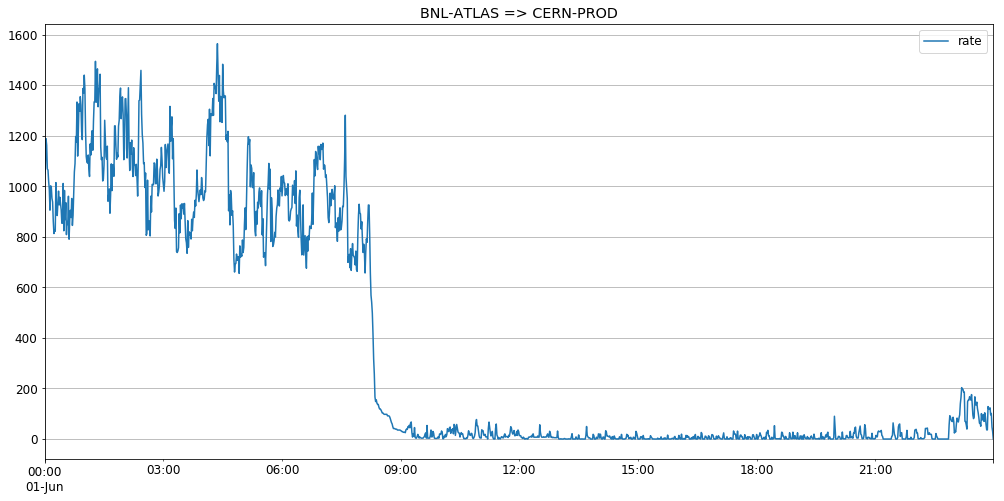

In [ ]:
links['BNL-ATLAS->CERN-PROD'].plot()

In [ ]:
links['BNL-ATLAS->CERN-PROD'].df['rate']

1496275200    1049.986659
1496275260    1071.205211
1496275320    1188.351608
1496275380    1162.419798
1496275440    1067.974220
1496275500    1064.469636
1496275560    1019.483638
1496275620     986.943679
1496275680     905.598859
1496275740    1001.868312
1496275800     997.324010
1496275860     952.226186
1496275920     937.826437
1496275980     862.318749
1496276040     813.034744
1496276100     826.544744
1496276160     822.162200
1496276220    1014.627620
1496276280     906.949638
1496276340     884.348385
1496276400     934.516859
1496276460     980.829735
1496276520     926.229812
1496276580     956.497962
1496276640     931.409539
1496276700     907.815865
1496276760     853.583554
1496276820     854.384840
1496276880    1011.219724
1496276940     824.043951
                 ...     
1496359800      87.180875
1496359860     167.030462
1496359920     135.489286
1496359980     135.489286
1496360040     146.131031
1496360100     119.921689
1496360160     105.042880
1496360220  

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


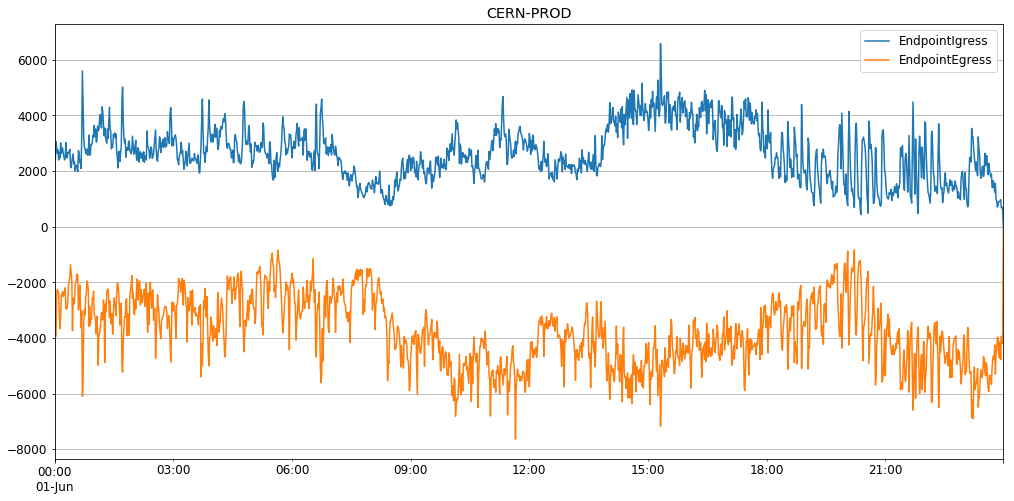

In [ ]:
endpoints['CERN-PROD'].plot_rates()

In [ ]:
links['BNL-ATLAS->CERN-PROD'].stats()

              rate  Data_Consolidation  Production_Input  Data_Rebalancing  \
count  1440.000000         1440.000000       1440.000000            1440.0   
mean    360.018845            0.586111        123.577778               0.0   
std     481.415366            2.563891        188.354012               0.0   
min       0.000000            0.000000          0.000000               0.0   
25%       2.699591            0.000000          0.000000               0.0   
50%      24.904272            0.000000          4.000000               0.0   
75%     871.117780            0.000000        254.250000               0.0   
max    1564.257743           49.000000        776.000000               0.0   

       Production_Output  User_Subscriptions  Data_Brokering      Express  
count        1440.000000         1440.000000          1440.0  1440.000000  
mean          448.367361            5.006250             0.0     0.302083  
std           766.374982            6.846523             0.0     1.52

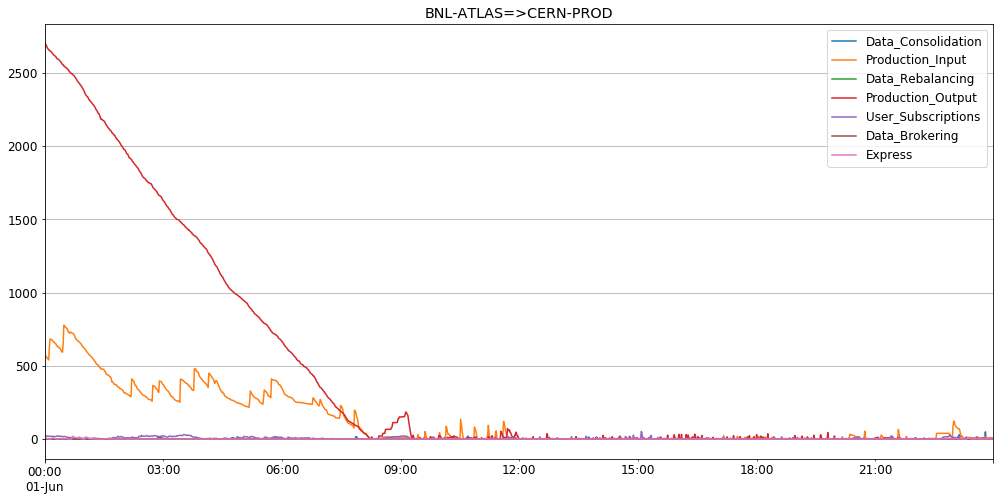

In [ ]:
links['BNL-ATLAS->CERN-PROD'].plot_queues_depths()

In [ ]:
endpoints['CERN-PROD'].stats()

       EndpointEgress  EndpointIgress  OutcomingTransfers  IncomingTransfers
count     1440.000000     1440.000000         1440.000000        1440.000000
mean      3759.626947     2659.121263          614.527778         366.551389
std       1222.792558      962.970929          269.247337         133.346894
min          0.000000        0.000000            0.000000           0.000000
25%       2815.305931     1997.716341          416.750000         279.000000
50%       3796.212754     2617.439266          526.000000         334.000000
75%       4678.235405     3283.187156          782.500000         418.000000
max       7636.522275     6579.308616         1828.000000        1315.000000


#### storing data into ES

In [ ]:
tp=int(len(links)/20)
for nl,link in enumerate(links.values()):
    if not nl%tp: print(nl," links indexed" )
    #print(link.get_json_docs())
    store(link.get_json_docs())
    #break
for endpoint in endpoints.values():
    print('endpoint indexed: ', endpoint.name)
    #print(endpoint.get_json_docs())
    store(endpoint.get_json_docs())
    #break

0  links indexed
366  links indexed
732  links indexed
1098  links indexed
1464  links indexed
1830  links indexed
2196  links indexed
2562  links indexed
2928  links indexed
3294  links indexed
3660  links indexed
4026  links indexed
4392  links indexed
4758  links indexed
5124  links indexed
5490  links indexed
5856  links indexed
6222  links indexed
6588  links indexed
6954  links indexed
7320  links indexed
endpoint indexed:  AGLT2
endpoint indexed:  UKI-LT2-Brunel
endpoint indexed:  UKI-SOUTHGRID-OX-HEP
endpoint indexed:  CA-VICTORIA-WESTGRID-T2
endpoint indexed:  INFN-ROMA3
endpoint indexed:  RO-07-NIPNE
endpoint indexed:  UNIGE-DPNC
endpoint indexed:  UKI-LT2-RHUL
endpoint indexed:  IFIC-LCG2
endpoint indexed:  MWT2
endpoint indexed:  GRIF-IRFU
endpoint indexed:  TR-10-ULAKBIM
endpoint indexed:  SARA-MATRIX
endpoint indexed:  TW-FTT
endpoint indexed:  INFN-NAPOLI-ATLAS
endpoint indexed:  INFN-BOLOGNA-T3
endpoint indexed:  EELA-UTFSM
endpoint indexed:  UKI-SCOTGRID-GLASGOW
endpoi

In [ ]:
print('done')

done
